RMSE: 67.16676241644748, R²: 0.8912719370692811


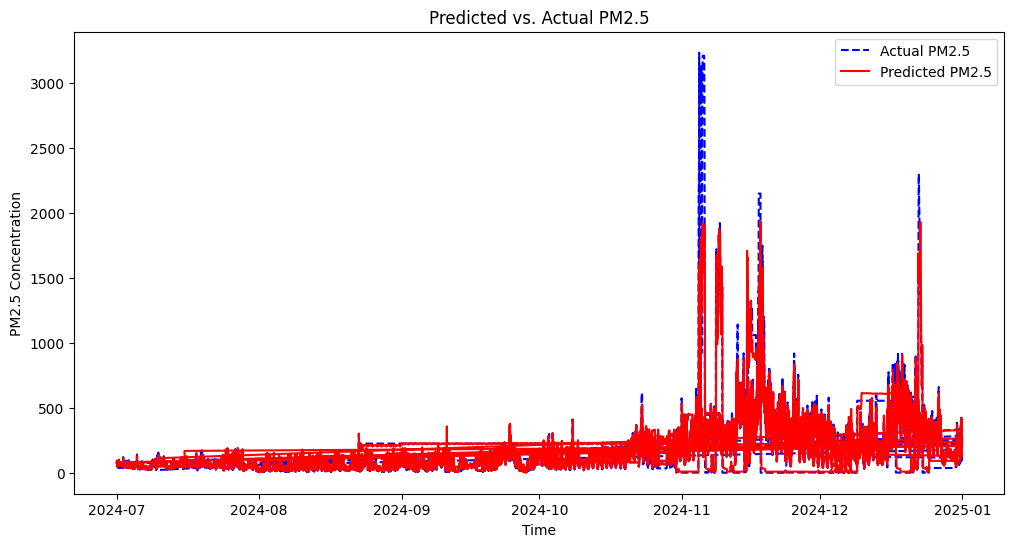

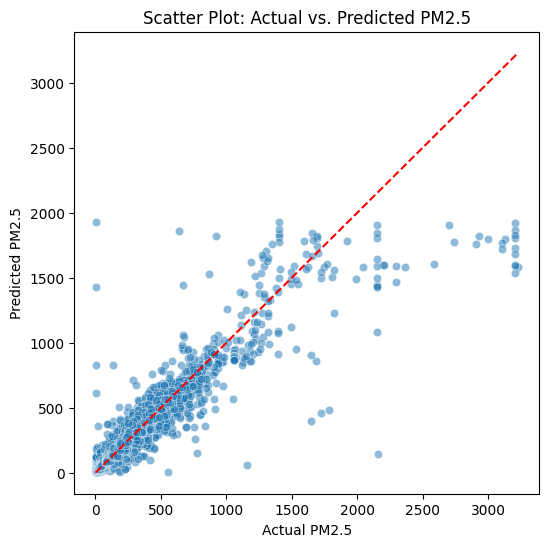

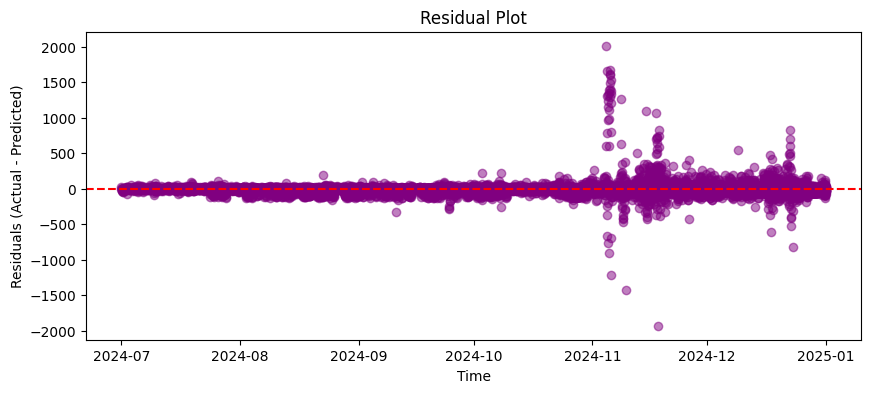

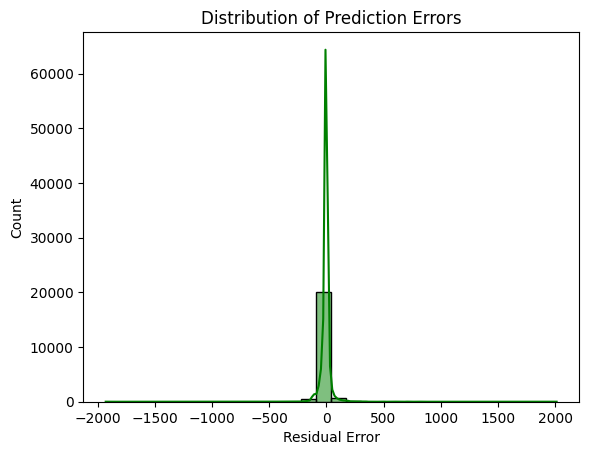

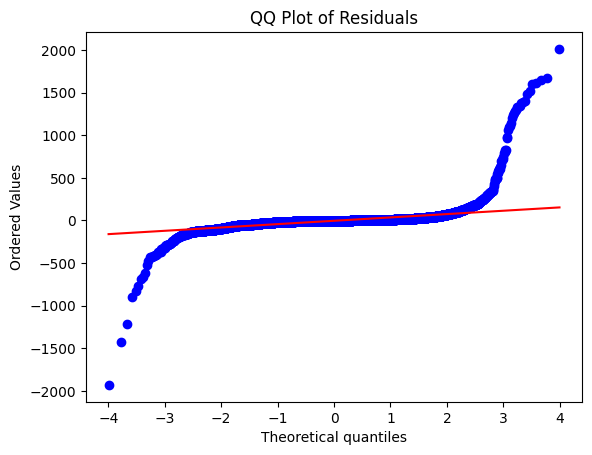

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

def load_and_preprocess_data(file_path):
    """Load dataset and preprocess columns."""
    df = pd.read_csv(file_path)
    df['data_created_time'] = pd.to_datetime(df['data_created_time'])
    df = df[['device_name', 'lat_median', 'long_median', 'data_created_time', 'id', 'pm_25', 'pm_10', 'no2', 'co', 'temp', 'rh']]
    return df

def extract_relevant_features(df):
    """Extract relevant features for modeling."""
    df_pm25_t_rh = df[['data_created_time', 'pm_25', 'temp', 'rh']].copy()
    df_pm25_t_rh.set_index('data_created_time', inplace=True)
    df_pm25_t_rh['hour'] = df_pm25_t_rh.index.hour
    df_pm25_t_rh['day'] = df_pm25_t_rh.index.day
    df_pm25_t_rh['month'] = df_pm25_t_rh.index.month
    df_pm25_t_rh['weekday'] = df_pm25_t_rh.index.weekday
    return df_pm25_t_rh

def create_lag_features(df, lags=24):
    """Generate lag features for PM2.5, temperature, and relative humidity."""
    for lag in range(1, lags + 1):  
        df[f'pm_25_lag_{lag}'] = df['pm_25'].shift(lag)
        df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
        df[f'rh_lag_{lag}'] = df['rh'].shift(lag)
    df.dropna(inplace=True)
    return df

def train_test_split(df, train_ratio=0.8):
    """Split dataset into training and testing sets."""
    train_size = int(train_ratio * len(df))
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    X_train, y_train = train.drop(columns=['pm_25']), train['pm_25']
    X_test, y_test = test.drop(columns=['pm_25']), test['pm_25']
    return X_train, y_train, X_test, y_test

def train_model(X_train, y_train):
    """Train a RandomForest model."""
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance."""
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse}, R²: {r2}')
    return y_test, y_pred

def plot_results(y_test, y_pred, test_index):
    """Visualize predictions and residuals."""
    plt.figure(figsize=(12, 6))
    plt.plot(test_index, y_test, label="Actual PM2.5", color='blue', linestyle='dashed')
    plt.plot(test_index, y_pred, label="Predicted PM2.5", color='red')
    plt.xlabel("Time")
    plt.ylabel("PM2.5 Concentration")
    plt.title("Predicted vs. Actual PM2.5")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual PM2.5")
    plt.ylabel("Predicted PM2.5")
    plt.title("Scatter Plot: Actual vs. Predicted PM2.5")
    plt.show()

def plot_residuals(y_test, y_pred, test_index):
    """Plot residuals and their distribution."""
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 4))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.scatter(test_index, residuals, alpha=0.5, color='purple')
    plt.xlabel("Time")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.show()
    
    sns.histplot(residuals, bins=30, kde=True, color="green")
    plt.xlabel("Residual Error")
    plt.title("Distribution of Prediction Errors")
    plt.show()

def plot_qq(residuals):
    """Generate QQ plot for residuals."""
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")
    plt.show()

# Main execution
file_path = '/Users/sumitchand/Downloads/Static_Ggn_input_bfill.csv'
df = load_and_preprocess_data(file_path)
df_pm25_t_rh = extract_relevant_features(df)
df_pm25_t_rh = create_lag_features(df_pm25_t_rh)
X_train, y_train, X_test, y_test = train_test_split(df_pm25_t_rh)

model = train_model(X_train, y_train)
y_test, y_pred = evaluate_model(model, X_test, y_test)

plot_results(y_test, y_pred, X_test.index)
plot_residuals(y_test, y_pred, X_test.index)
plot_qq(y_test - y_pred)